# Credit Card Fraud Detection
## 1 Overview
### 1.1 Background

Credit card fraud is defined as the use of someone else's credit card information to make unauthorized transactions. This can include card-not-present fraud, identity theft, and stolen credit cards. According to the December 2021 Nilson Report: 
- card issuers, merchants, acquirers of ATM transactions and acquirers of merchant transactions incurred gross fraud losses of \\$28.58 billion in 2020, with the U.S. accounting for 35.8% of global card fraud

- global general purpose brand cards (i.e., Visa, Mastercard, UnionPay, American Express, Discover/Diners Club and JCB) accounted for a combined \\$34.173 trillion in total volume in 2020. Their losses to fraud in 2020 were \\$25.27 billion, or about 7.4 cents per $100

- it is estimated that over the next 10 years, card industry losses to fraud will collectively amount to \\$408.50 billion

Despite the use of more and more sophisticated methods for preventing fraud, fraud is expected to continue to rise as thieves become more sophisticated and the percentage of transactions done online continues to increase.
 

### 1.2 Goals
The overarching goal of this project is to build a machine learning model to detect credit card fraud using a publicly available dataset.

### 1.3 Data
The __[Kaggle Credit Card Fraud Detection](https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud)__ dataset is used for this analysis. This is a widely used dataset for analysis of credit card fraud. This dataset presents transactions that occurred over a two day period, having 492 frauds out of 284,807 transactions. This dataset is highly unbalanced; the positive class (frauds) account for 0.172% of all transactions.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import seaborn.objects as so
from zipfile import ZipFile
from scipy import stats

from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler

import os # accessing directory structure

## 2 Data Wrangling
### 2.1 Dataset Overview
This is a fairly clean dataset. The original dataset could not be made publicly available, so a PCA was performed on it, resulting in 28 features. For the moment, we will keep all features, but will assume that most of the variance can be explained by the first 4 - 5 features. We will take this into account when we run our models.
### 2.2 Data Field Definitions
Data Field Definitions:
- Time = Number of seconds elapsed since the first transaction in the database
- V1 - V28:  the principal components obtained with PCA
- Amount = transaction amount in Euros
- Class: the response variable, 1 in case of fraud and 0 otherwise

In [2]:
file_name = "./Kaggle_CreditCardFraudDetection.zip"

zf = ZipFile(file_name) 
creditcard_df = pd.read_csv(zf.open('creditcard.csv'))

In [3]:
creditcard_df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [ ]:
# creditcard_df['Minutes'] = creditcard_df.Time/60.
# creditcard_df['Hours'] = creditcard_df.Minutes/60.

In [4]:
# Note: Time == Number of seconds elapsed between the first transaction and this transaction
creditcard_df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,3.918649e-15,5.682686e-16,-8.761736e-15,2.811118e-15,-1.552103e-15,2.040130e-15,-1.698953e-15,-1.893285e-16,-3.147640e-15,...,1.473120e-16,8.042109e-16,5.282512e-16,4.456271e-15,1.426896e-15,1.701640e-15,-3.662252e-16,-1.217809e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


In [5]:
creditcard_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

**There are no null values, and all fields are numeric.**

In [6]:
print("Total None values:", creditcard_df.isna().any().sum())

Total None values: 0


In [7]:
creditcard_df["Class"].value_counts()

0    284315
1       492
Name: Class, dtype: int64

### 2.3 Remove Outliers

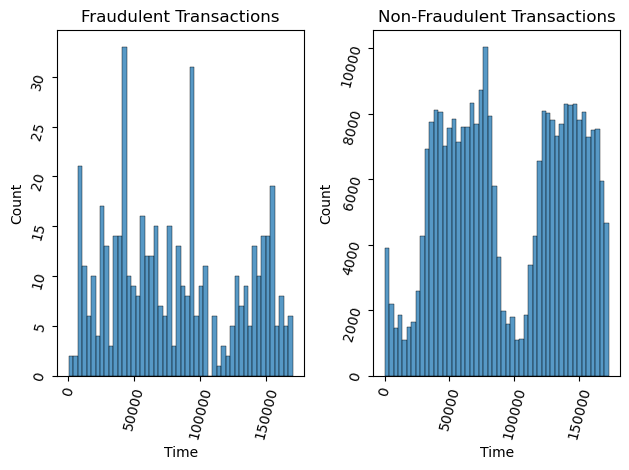

In [8]:
fig, axes = plt.subplots(1,2)
trans_plots = []
trans_plots.append(sns.histplot(creditcard_df["Time"][creditcard_df.Class == 1], bins=50, ax=axes[0]))
trans_plots[0].set_title("Fraudulent Transactions")
trans_plots[0].tick_params(labelrotation=75)
trans_plots.append(sns.histplot(creditcard_df["Time"][creditcard_df.Class == 0], bins=50, ax=axes[1]))
trans_plots[1].set_title("Non-Fraudulent Transactions")
trans_plots[1].tick_params(labelrotation=75)
#plt.subplots_adjust(hspace=0.5)
fig.tight_layout(h_pad=2)
plt.show();

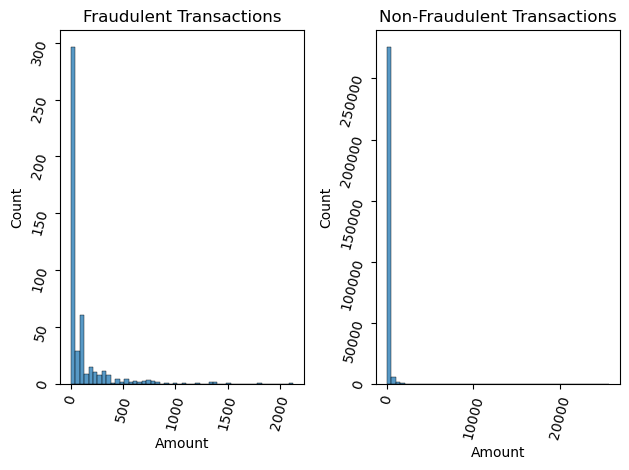

In [9]:
fig, axes = plt.subplots(1,2)
trans_plots = []
trans_plots.append(sns.histplot(creditcard_df["Amount"][creditcard_df.Class == 1], bins=50, ax=axes[0]))
trans_plots[0].set_title("Fraudulent Transactions")
trans_plots[0].tick_params(labelrotation=75)
trans_plots.append(sns.histplot(creditcard_df["Amount"][creditcard_df.Class == 0], bins=50, ax=axes[1]))
trans_plots[1].set_title("Non-Fraudulent Transactions")
trans_plots[1].tick_params(labelrotation=75)
#plt.subplots_adjust(hspace=0.5)
fig.tight_layout(h_pad=2)
plt.show();

**It looks like there are some outliers in the Amount feature.**

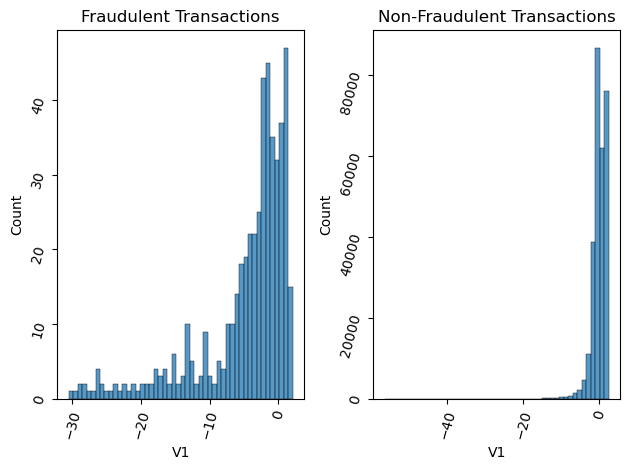

In [10]:
fig, axes = plt.subplots(1,2)
trans_plots = []
trans_plots.append(sns.histplot(creditcard_df["V1"][creditcard_df.Class == 1], bins=50, ax=axes[0]))
trans_plots[0].set_title("Fraudulent Transactions")
trans_plots[0].tick_params(labelrotation=75)
trans_plots.append(sns.histplot(creditcard_df["V1"][creditcard_df.Class == 0], bins=50, ax=axes[1]))
trans_plots[1].set_title("Non-Fraudulent Transactions")
trans_plots[1].tick_params(labelrotation=75)
#plt.subplots_adjust(hspace=0.5)
fig.tight_layout(h_pad=2)
plt.show();

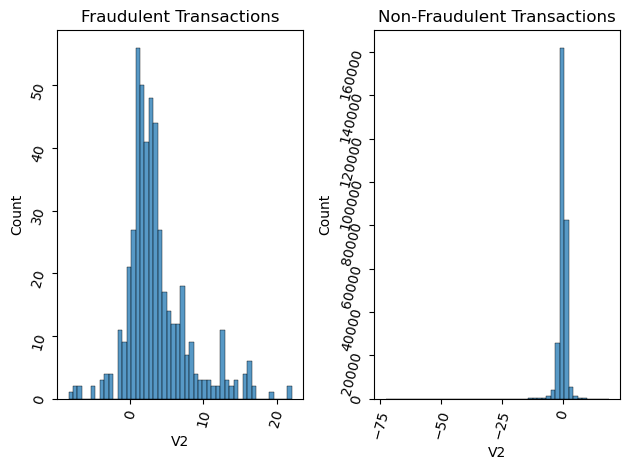

In [11]:
fig, axes = plt.subplots(1,2)
trans_plots = []
trans_plots.append(sns.histplot(creditcard_df["V2"][creditcard_df.Class == 1], bins=50, ax=axes[0]))
trans_plots[0].set_title("Fraudulent Transactions")
trans_plots[0].tick_params(labelrotation=75)
trans_plots.append(sns.histplot(creditcard_df["V2"][creditcard_df.Class == 0], bins=50, ax=axes[1]))
trans_plots[1].set_title("Non-Fraudulent Transactions")
trans_plots[1].tick_params(labelrotation=75)
#plt.subplots_adjust(hspace=0.5)
fig.tight_layout(h_pad=2)
plt.show();

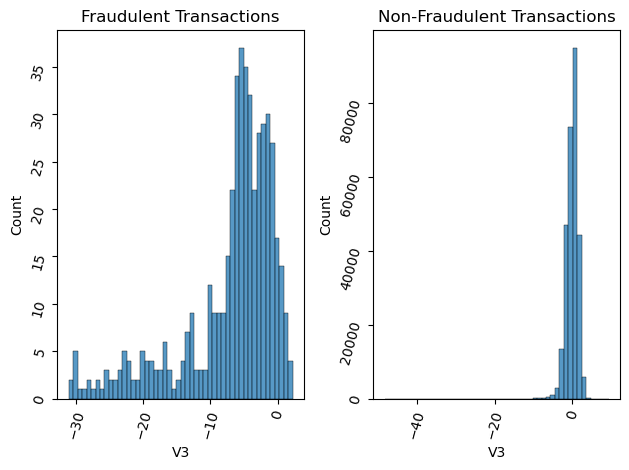

In [12]:
fig, axes = plt.subplots(1,2)
trans_plots = []
trans_plots.append(sns.histplot(creditcard_df["V3"][creditcard_df.Class == 1], bins=50, ax=axes[0]))
trans_plots[0].set_title("Fraudulent Transactions")
trans_plots[0].tick_params(labelrotation=75)
trans_plots.append(sns.histplot(creditcard_df["V3"][creditcard_df.Class == 0], bins=50, ax=axes[1]))
trans_plots[1].set_title("Non-Fraudulent Transactions")
trans_plots[1].tick_params(labelrotation=75)
#plt.subplots_adjust(hspace=0.5)
fig.tight_layout(h_pad=2)
plt.show();

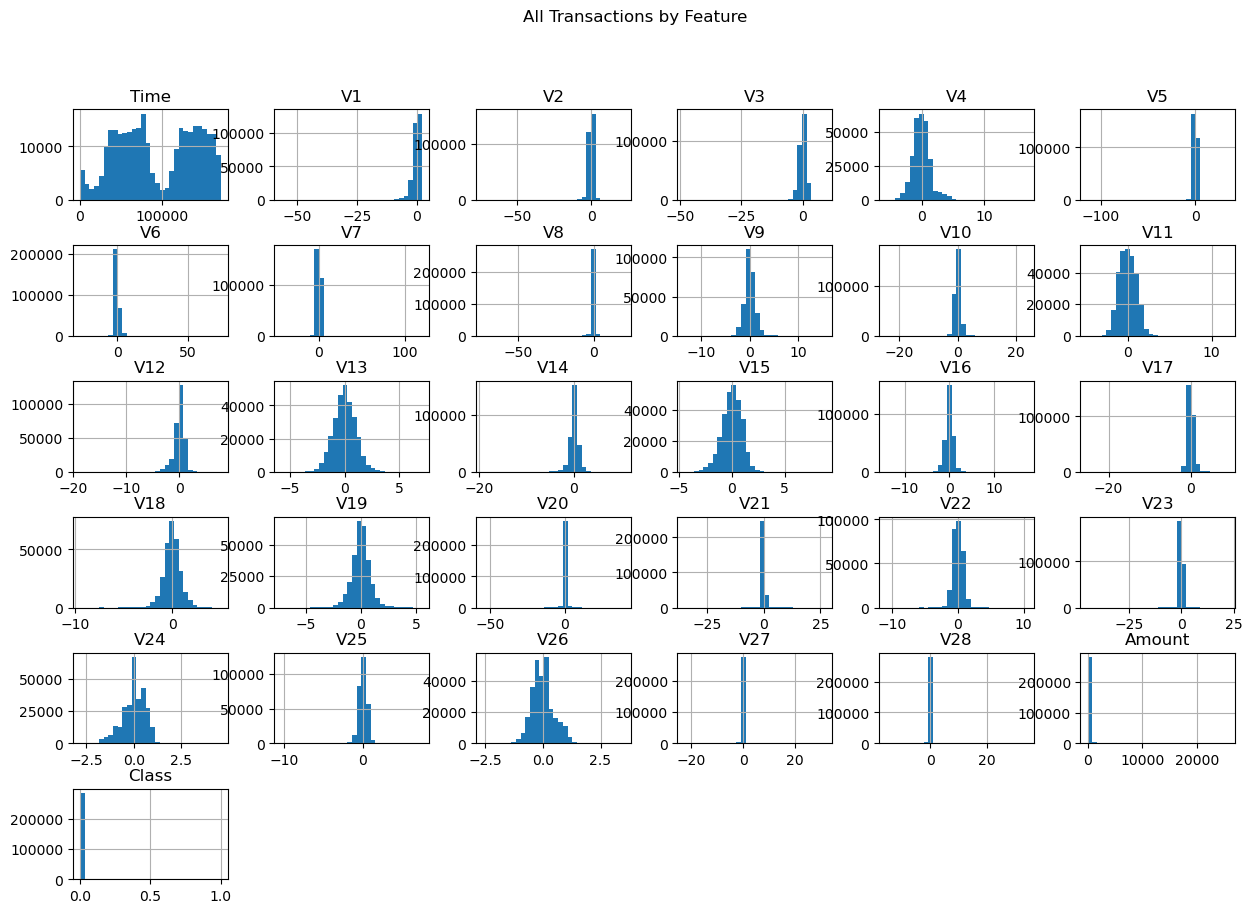

In [13]:
## Distributions of All Transactions
creditcard_df.hist(bins=30, figsize=(15,10))
plt.subplots_adjust(hspace=0.5)
plt.suptitle('All Transactions by Feature');

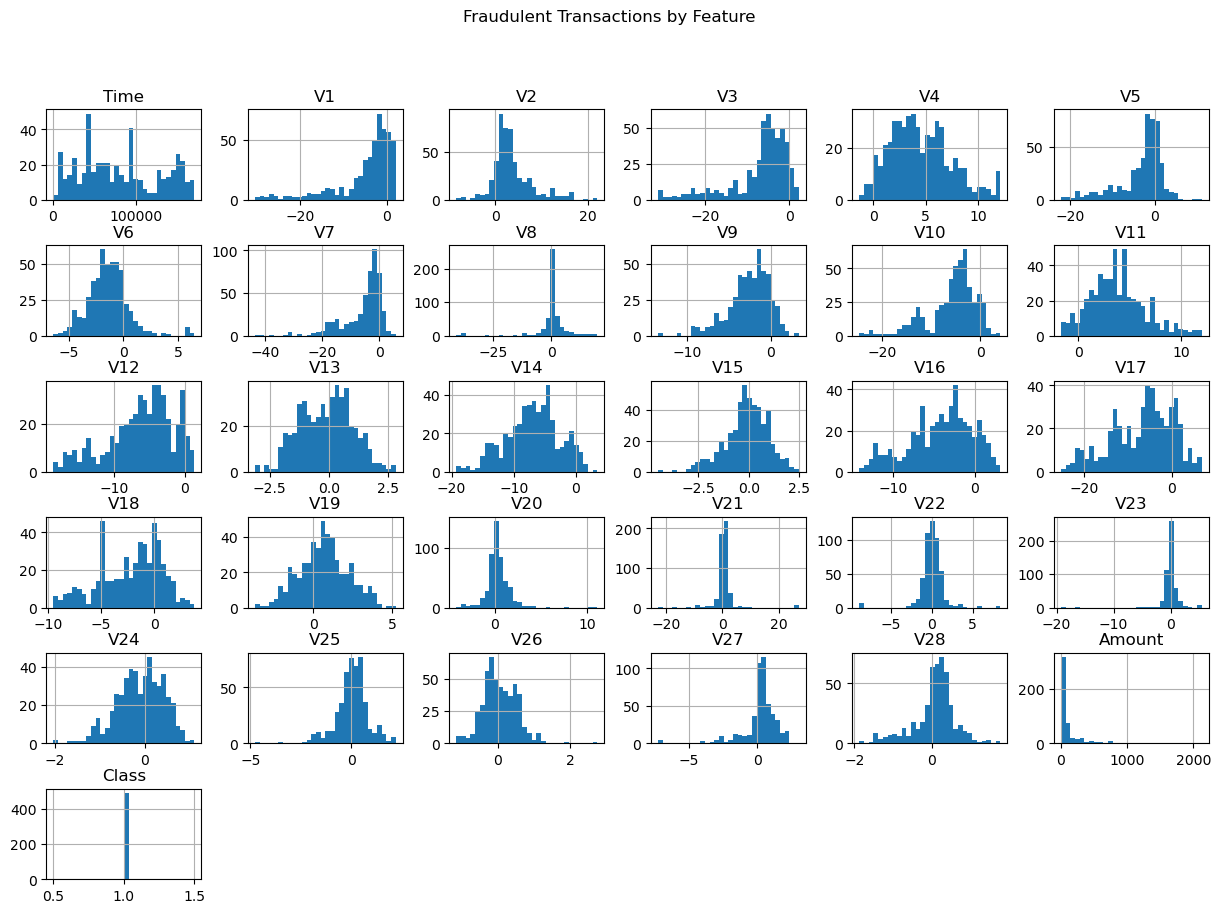

In [14]:
## Distributions of fraudulent Transactions
creditcard_df[creditcard_df.Class == 1].hist(bins=30, figsize=(15,10))
plt.subplots_adjust(hspace=0.5)
plt.suptitle('Fraudulent Transactions by Feature');

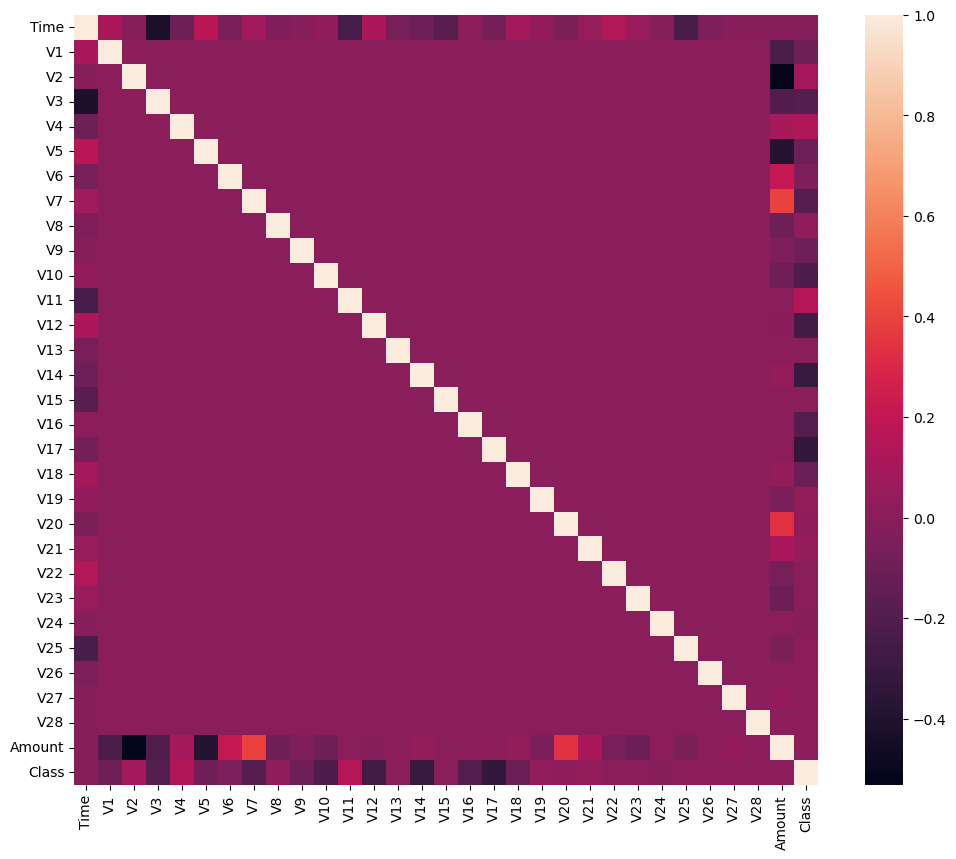

In [15]:
plt.subplots(figsize=(12,10))
sns.heatmap(creditcard_df.corr());   ## change the range to (-0.2,0.2)

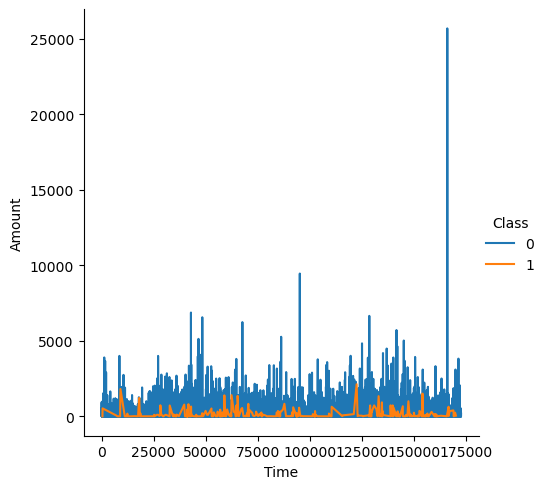

In [16]:
sns.relplot(data=creditcard_df, kind="line", x="Time", y="Amount", hue="Class", errorbar=None)

**Drop rows where Amount == 0. We don't know what a 0 amount signifies.**

In [17]:
creditcard_df.drop(creditcard_df[creditcard_df.Amount == 0].index, inplace=True)

In [18]:
creditcard_df.shape

(282982, 31)

In [19]:
creditcard_df['Amount'].describe()

count    282982.000000
mean         88.919401
std         250.824374
min           0.010000
25%           5.990000
50%          22.490000
75%          78.000000
max       25691.160000
Name: Amount, dtype: float64

**Remove outliers: rows where Amount > 3 stdevs from mean. Make a separate dataset so we can try the model with and without outliers. The outliers might be valid for this data.**

In [20]:
valid_df = creditcard_df[(creditcard_df.Class==0)]
valid_outliers_df = valid_df[(np.abs(stats.zscore(valid_df['Amount'])) >= 3)]
valid_outliers_df['Amount'].sort_values()

35329       841.27
18090       841.38
239884      841.50
127893      841.50
50564       841.69
            ...   
54018     11898.09
46841     12910.93
151296    18910.00
58465     19656.53
274771    25691.16
Name: Amount, Length: 4049, dtype: float64

In [21]:
valid_df.shape

(282517, 31)

In [22]:
## % of valid transactions that are outliers
4049*100/282517

1.4331880913360966

In [23]:
creditcard_df[(creditcard_df.Class==1)].shape

(465, 31)

In [24]:
fraud_df = creditcard_df[(creditcard_df.Class==1)]
fraud_outliers_df = fraud_df[(np.abs(stats.zscore(fraud_df['Amount'])) >= 3)] 
fraud_outliers_df['Amount'].sort_values()

203328     925.31
233258     996.27
249239    1096.99
10690     1218.89
199896    1335.00
95597     1354.25
81609     1389.56
89190     1402.16
249167    1504.93
6971      1809.68
176049    2125.87
Name: Amount, dtype: float64

In [25]:
## % of fraudulent transactions that are outliers
11*100/465

2.3655913978494625

In [26]:
all_outliers_df = creditcard_df[(np.abs(stats.zscore(creditcard_df['Amount'])) >= 3)] 
all_outliers_df['Amount'].sort_values()

239884      841.50
127893      841.50
50564       841.69
279594      841.77
5645        841.96
            ...   
54018     11898.09
46841     12910.93
151296    18910.00
58465     19656.53
274771    25691.16
Name: Amount, Length: 4058, dtype: float64

In [27]:
creditcard_df[creditcard_df.Amount != 0].shape

(282982, 31)

In [28]:
## % of total transactions that are outliers
4058*100/282982

1.4340134708214656

In [29]:
## set outlier threshold to min outlier amount for all transactions
MAX_AMOUNT = 841.50
creditcard_df[(creditcard_df.Class==1) & \
              (creditcard_df.Amount >= MAX_AMOUNT)].shape

(11, 31)

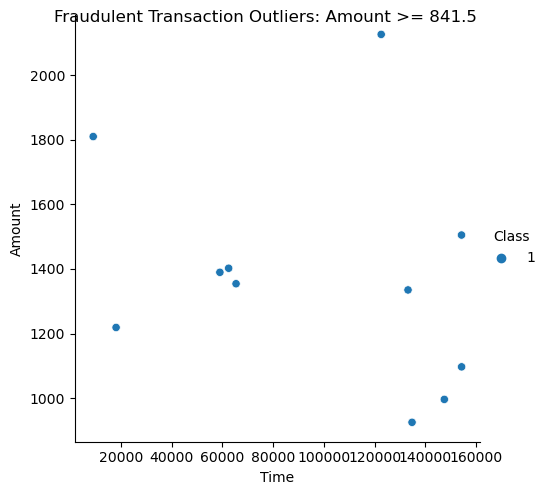

In [33]:
rel = sns.relplot(data=fraud_outliers_df, x="Time", y="Amount", hue="Class") #, kind='line', errorbar=None)

rel.fig.suptitle("Fraudulent Transaction Outliers: Amount >= " + str(MAX_AMOUNT));

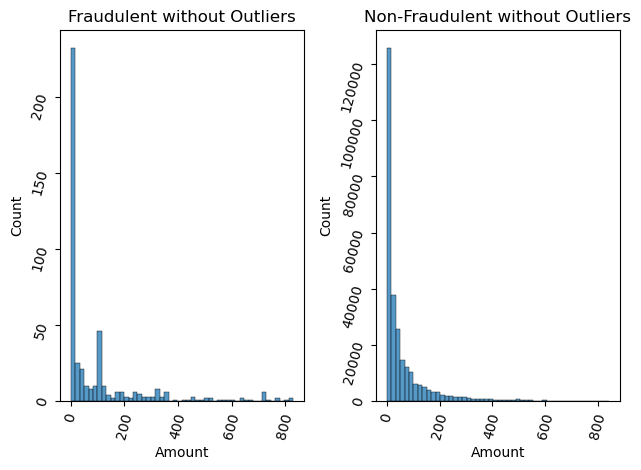

In [34]:
fig, axes = plt.subplots(1,2)
trans_plots = []
trans_plots.append(sns.histplot(creditcard_df["Amount"][(creditcard_df.Class == 1) & (creditcard_df.Amount <= MAX_AMOUNT)], 
                                bins=50, ax=axes[0]))
trans_plots[0].set_title("Fraudulent without Outliers")
trans_plots[0].tick_params(labelrotation=75)
trans_plots.append(sns.histplot(creditcard_df["Amount"][(creditcard_df.Class == 0)\
                                                        & (creditcard_df.Amount <= MAX_AMOUNT)], 
                                bins=50, ax=axes[1]))
trans_plots[1].set_title("Non-Fraudulent without Outliers")
trans_plots[1].tick_params(labelrotation=75)
plt.subplots_adjust(hspace=0.5)
fig.tight_layout(h_pad=2)
plt.show();

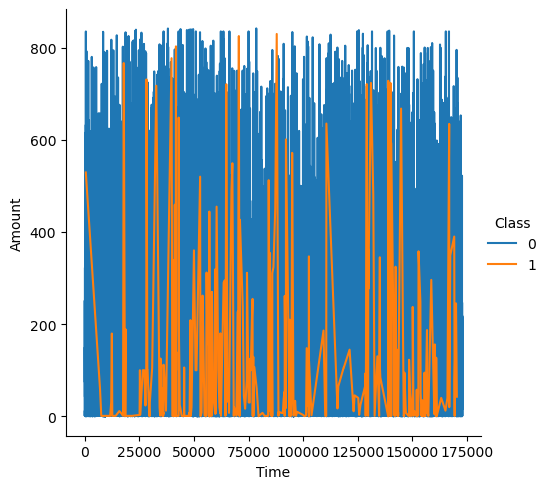

In [32]:
sns.relplot(data=creditcard_df[(creditcard_df.Amount <= MAX_AMOUNT)], kind="line", x="Time", y="Amount", hue="Class", errorbar=None)

**The distributions of amounts look better now. Make a separate dataframe with outliers dropped.**

In [35]:
creditcard_df.shape

(282982, 31)

In [36]:
## drop outliers
cc_no_outliers_df = creditcard_df.drop(creditcard_df[creditcard_df.Amount > MAX_AMOUNT].index, inplace = False)

In [37]:
cc_no_outliers_df.shape

(278926, 31)

In [38]:
creditcard_df.shape

(282982, 31)

In [39]:
creditcard_df.Amount.describe()

count    282982.000000
mean         88.919401
std         250.824374
min           0.010000
25%           5.990000
50%          22.490000
75%          78.000000
max       25691.160000
Name: Amount, dtype: float64

In [40]:
cc_no_outliers_df.Amount.describe()

count    278926.000000
mean         67.449216
std         116.458505
min           0.010000
25%           5.760000
50%          21.440000
75%          74.100000
max         841.500000
Name: Amount, dtype: float64

In [41]:
count_by_second = pd.DataFrame(creditcard_df.groupby(['Time','Class'])['Amount'].count().sort_values(ascending=False))
count_by_second.reset_index(inplace=True)
count_by_second.columns=['Seconds','Class','Count']
count_by_second
count_by_second[(count_by_second.Count >= 2) & (count_by_second.Class == 1)]

,Seconds,Class,Count
1424,68207.0,1,6
9141,93879.0,1,4
9175,93860.0,1,4
9315,93853.0,1,4
12360,94362.0,1,4
44311,85285.0,1,2
44768,84204.0,1,2
44961,148053.0,1,2


Number of fraudulent transactions/second does not seem useful. It must take more than one second to complete a transaction. A rolling window would be a better way to look at clusters of transactions.

In [42]:
#creditcard_df[(creditcard_df.Time == 138193) and (creditcard_df.Class == 1)]
creditcard_df[(creditcard_df.Time == 94362)]

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
151006,94362.0,-26.457745,16.497472,-30.177317,8.904157,-17.8926,-1.227904,-31.197329,-11.43892,-9.462573,...,-8.755698,3.460893,0.896538,0.254836,-0.738097,-0.966564,-7.263482,-1.324884,1.0,1
151007,94362.0,-26.457745,16.497472,-30.177317,8.904157,-17.8926,-1.227904,-31.197329,-11.43892,-9.462573,...,-8.755698,3.460893,0.896538,0.254836,-0.738097,-0.966564,-7.263482,-1.324884,1.0,1
151008,94362.0,-26.457745,16.497472,-30.177317,8.904157,-17.8926,-1.227904,-31.197329,-11.43892,-9.462573,...,-8.755698,3.460893,0.896538,0.254836,-0.738097,-0.966564,-7.263482,-1.324884,1.0,1
151009,94362.0,-26.457745,16.497472,-30.177317,8.904157,-17.8926,-1.227904,-31.197329,-11.43892,-9.462573,...,-8.755698,3.460893,0.896538,0.254836,-0.738097,-0.966564,-7.263482,-1.324884,1.0,1


### 2.4 Investigate Duplicates

In [43]:
dupes_df = creditcard_df.groupby(['Class','Amount','Time','V1'])['Time'].count().sort_values(ascending=False).reset_index(name='Count')
dupes_df.drop(dupes_df[dupes_df.Count == 1].index, inplace=True)

In [44]:
dupes_df.head()

,Class,Amount,Time,V1,Count
0,0,1.51,163152.0,-1.203617,18
1,0,7.56,163152.0,-1.196037,18
2,0,0.76,170731.0,2.033492,9
3,0,0.76,43153.0,-2.086016,9
4,1,1.00,68207.0,-13.192671,6


In [45]:
dupes_df[(dupes_df.Class == 0) & (dupes_df.Amount.map(lambda x: x.is_integer()))]

,Class,Amount,Time,V1,Count
18,0,1.0,141650.0,1.964854,4
22,0,5.0,1548.0,-1.559446,4
29,0,18.0,50608.0,-0.988271,4
31,0,1.0,84646.0,1.114698,4
32,0,1.0,134239.0,2.095750,4
...,...,...,...,...,...
724,0,79.0,71861.0,-1.553554,2
727,0,16.0,31557.0,-3.965824,2
737,0,1.0,57869.0,1.173806,2
741,0,1.0,55808.0,1.260058,2


In [46]:
nonfraud_dupes = dupes_df[dupes_df.Class == 0]['Count'].sum()
print('There are ' + str(nonfraud_dupes) + ' non-fraud duplicates, or '\
      + str(round(nonfraud_dupes*100/creditcard_df[creditcard_df.Class == 0]['Amount'].count(),2)) + '%')

There are 1798 non-fraud duplicates, or 0.64%


In [47]:
fraud_dupes = dupes_df[dupes_df.Class == 1]['Count'].sum()
print('There are ' + str(fraud_dupes) + ' fraud duplicates, or '\
      + str(round(fraud_dupes*100/creditcard_df[creditcard_df.Class == 0]['Amount'].count(),2)) + '%')

There are 28 fraud duplicates, or 0.01%


**Make a separate dataframe with duplicates dropped. Try the model with and without duplicates.**

In [48]:
cc_no_dupes_df = creditcard_df.drop_duplicates(subset=['Class','Amount','Time','V1'], keep='first', inplace=False)

In [49]:
(cc_no_dupes_df.shape, creditcard_df.shape)

((281918, 31), (282982, 31))

In [66]:
## TRY RANDOM FOREST, split data into train and test
from sklearn import __version__ as sklearn_version
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, learning_curve
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay
import datetime

#from library.sb_utils import save_file

In [51]:
X_train, X_test, y_train, y_test = train_test_split(creditcard_df.drop(columns='Class'), 
                                                    creditcard_df.Class, test_size=0.3, 
                                                    random_state=47)

In [52]:
X_train.shape

(198087, 30)

In [53]:
X_test.shape

(84895, 30)

In [54]:
y_test.value_counts()

0    84753
1      142
Name: Class, dtype: int64

In [55]:
y_train.value_counts()

0    197764
1       323
Name: Class, dtype: int64

In [56]:
136/(316+138)

0.29955947136563876

**Run Random Forest Classifier Model**

In [57]:
rf = RandomForestClassifier()
rf.fit(X_train, y_train)

RandomForestClassifier()

In [76]:
RF_pipe = make_pipeline(
   SimpleImputer(strategy='median'),
    StandardScaler(),
    RandomForestClassifier
)

In [77]:
rf_default_cv_results = cross_validate(RF_pipe, X_train, y_train, cv=5)

C:\Users\carol\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
5 fits failed out of a total of 5.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\carol\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\carol\Anaconda3\lib\site-packages\sklearn\pipeline.py", line 394, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
TypeError: fit() missing 1 required positional argument: 'y'

  warnings.warn(some_fits_failed_message, FitFailedWarning)


In [78]:
y_pred = rf.predict(X_test)

In [84]:
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 99.96%


**Now try xgboost**

In [80]:
import xgboost as xgb

In [81]:
model = xgb.XGBClassifier()
model.fit(X_train, y_train)
print(); print(model)


XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...)


In [82]:
# make predictions for test data
y_pred = model.predict(X_test)
predictions = [round(value) for value in y_pred]

In [83]:
# evaluate predictions
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 99.96%
